# #Rsoft Circuit Maker

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import rspie as rs
from matplotlib import pyplot as plt
import cmasher as cm
import os
import re
from subprocess import check_output

## ##Calculating modes in a step-index fiber

In [8]:
def waveguide_modes(extra_config, cmd_params, circuits_dir, cleanup=True, verbose=False):
    '''
    This configures a circuit file for finding waveguide modes.
    Parameters
    ----------
    extra_config (dict): fiber configuration parameters, must include the following keys
        mode_method (int): mode method (1: Correlation, 2: Iterative)
        Core_index (float): core index
        Cladding_index (float): cladding index
        Core_radius (float): core radius
        free_space_wavelength (float): free space wavelength
        polarization (int): polarization (0: TE, 1: TM)
        mode_output_format (str): mode output format (OUTPUT_REAL_IMAG, OUTPUT_COMPLEX, OUTPUT_MAGNITUDE)
        launch_type (str): launch type (LAUNCH_GAUSSIAN, )

    cmd_params (dict): command line parameters, must include the following keys
        mode_set (str): range of modes to be computed in the format '0-n'
        prefix (str): prefix for the computed files (distinct from filename)
    
    circuit_dir (str): base directory where files are saved, a subdirectory inside of this
        directory will be created using the prefix

    cleanup (bool): remove old mode files
    
    verbose (bool): print extra information

    Returns
    -------
    output (dict): with the following key, values
        neffs (np.ndarray): effective indices
        V (float): V number
        NA (float): numerical aperture
        numModes_approx (float): approximate number of modes
        mode_files (list): list of mode files
        config (dict): configuration dictionary
        extra_config  (dict): extra configuration dictionary
        cmd_params (dict): command line parameters
        simulscript (str): path to the simulation script
        simulscript_txt (str): text of the simulation script
    '''
    if 'comments' in extra_config:
        comments = extra_config['comments']
        del extra_config['comments']
    else:
        comments = ''
    
    mode_dir = os.path.join(circuits_dir, cmd_params['prefix'])
    if not os.path.exists(mode_dir):
        os.mkdir(mode_dir)
    os.chdir(mode_dir)

    if 'polarization' in extra_config:
        pol = {0:'TE', 1:'TM'}[extra_config['polarization']]
    else:
        pol = None

    # Remove old mode files
    if cleanup:
        files = os.listdir(mode_dir)
        mode_files = [os.path.join(mode_dir, f) for f in files if re.match('[m,p]\d+', f.split('.')[-1])]
        for f in mode_files:
            os.remove(f)
    
    # Compute a few useful figures
    n_core = extra_config['Core_index']
    n_cladding = extra_config['Cladding_index']
    core_radius = extra_config['Core_radius']
    wavelength = extra_config['free_space_wavelength']
    NA = np.sqrt(n_core**2 - n_cladding**2)
    V_num = 2 * np.pi * core_radius / wavelength * NA
    numModes_approx = 4 * V_num**2 / np.pi**2
    if verbose:
        print('There should be about %.1f modes.' % numModes_approx)

    config = {'vars'   : {}, 
            'segments' : [],
            'monitors' : [],
            'launch_fields' : {}
            }

    config_text = '''
    filename = step-index-fiber-modes.ind
    Box_width = 12*Core_radius
    Cladding_index = {Cladding_index}
    Core_delta = Core_index-Cladding_index
    Core_index = {Core_index}
    Core_radius = {Core_radius}
    mode_output_format = {mode_output_format}
    Fiber_height = 1
    Grid_resolution = 0.05
    Index_resolution = 0.1
    Mode_resolution = 0.1
    PML_width = 0.3
    Xmax = Box_width/2
    Ymax = Box_width/2
    Zmax = Fiber_height
    alpha = 0
    background_index = 1
    boundary_max = Xmax
    boundary_max_y = Ymax
    boundary_min = -Xmax
    boundary_min_y = -Ymax
    cad_aspectratio = 1
    cad_aspectratio_y = 1
    color_outline = 14
    color_scale = fireice.scl
    delta = Core_index-Cladding_index
    dimension = 3
    domain_max = Zmax
    eim = 0
    free_space_wavelength = {free_space_wavelength}
    idbpm_convergence_warning = 0
    k0 = (2*pi)/free_space_wavelength
    launch_align_file = 1
    launch_type = {launch_type}
    launch_tilt = {launch_tilt}
    mode_output_format = OUTPUT_REAL_IMAG
    neff_log = 1
    pml_width_x = PML_width
    pml_width_y = PML_width
    polarization = {polarization}
    rcwa_index_res_x = Index_resolution
    rcwa_index_res_y = Index_resolution
    rcwa_index_res_z = Index_resolution
    rcwa_output_field = 1
    rcwa_output_field_ex = 1
    rcwa_output_field_ey = 1
    rcwa_output_field_ez = 1
    rcwa_output_field_format = 1
    rcwa_output_option = 1
    sim_tool = ST_BEAMPROP
    structure = STRUCT_FIBER
    vector = 1
    '''.format(**extra_config)

    config['vars'] = rs.selfref_def_parser(config_text)

    config['segments'] = [
        rs.selfref_def_parser('''structure = STRUCT_FIBER
        color = 2
        comp_name = core
        extended = 1
        begin.x = 0
        begin.z = 0
        begin.height = 2*Core_radius
        begin.width = 2*Core_radius
        begin.delta = Core_delta
        end.x = 0
        end.y = 0
        end.z = Fiber_height
        end.height = 2*Core_radius
        end.width = 2*Core_radius
        end.delta = Core_delta''', config['vars'])
        ]
    config['monitors'] = [
        rs.selfref_def_parser('''
        profile_type = PROF_INACTIVE
        color = 2
        type = TIMEMON_EXTENDED
        timeaverage = 2
        monitoroutputmask = 128
        xsize = 2*Core_radius
        ysize = 2*Core_radius
        begin.x = 0
        begin.z = 0
        begin.height = 2*Core_radius
        begin.width = 2*Core_radius
        ''', config['vars'])
    ]
    config['launch_fields'] = [
        rs.selfref_def_parser('''
        launch_pathway = 0
        launch_type = LAUNCH_GAUSSIAN
        launch_tilt = 1
        launch_mode = 2
        launch_align_file = 1
        ''', config['vars'])
    ]
    fiber = rs.PhotoCircuit(config)
    fiber.save_to_file()
    cmd = ['bsimw32', fiber.full_filename, 'wait=0']
    num_params = ['%s=%f' % (k, v) for k, v in cmd_params.items() if type(v) in [int, float, np.float64]]
    str_params = ['%s=%s' % (k, v) for k, v in cmd_params.items() if type(v) == str]
    cmd = cmd + num_params + str_params
    check_output(cmd, shell=True)

    # Query the filenames for the computed fields and effective refractive indices
    files = os.listdir(mode_dir)
    mode_files = [os.path.join(mode_dir,f) for f in files if re.match('m\d+', f.split('.')[-1])]
    try:
        nef_file = os.path.join(mode_dir, extra_config['prefix']+'.nef')
        neffs = np.genfromtxt(nef_file)
        if len(neffs.shape) == 1:
            neffs = neffs.reshape((1,neffs.shape[0]))
        neffs = neffs[:,1:]
        neffs = neffs[:,0]+1j*neffs[:,1]
        if np.max(np.imag(neffs)) == 0:
            neffs = np.real(neffs)
        neffs = neffs.T
    except:
        neffs = None
    
    # Put all the output together in a dictionary
    output = {'neffs': neffs,
              'V':V_num,
              'NA':NA,
              'numModes_approx': numModes_approx,
              'mode_files': mode_files,
              'config': config,
              'simulscript': fiber.full_filename,
              'extra_config': extra_config,
              'cmd_params': cmd_params,
              'simulscript_txt': fiber.circuit_text}
    
    # If there are comments put them back in the ouput
    if comments:
        output['comments'] = comments
    return output

def load_mode_data(filename):
    '''This function can be used to read
    the data stores in the output fiels from
    the Photonic Tools mode solver.
    
    Parameters
    ----------
    filename : str

    Returns
    -------
    extent (tuple), lines(np.array), n_eff (np.array)
    
    '''
    with open(filename, 'r') as f:
        lines = f.readlines()
        metadata = lines[:4]
        n_eff = metadata[2].split(' ')[5]
        output_type = lines[2].split(' ')[4]
        xmin, xmax = metadata[2].split(' ')[1:3]
        zmin, zmax = metadata[3].split(' ')[1:3]
        lines = lines[4:]
        lines = [line.strip() for line in lines]
        lines = [line.split() for line in lines]
        lines = [[float(x) for x in line] for line in lines]
        extent = (float(xmin), float(xmax), float(zmin), float(zmax))
    lines = np.array(lines).T
    if output_type == 'OUTPUT_REAL_IMAG_3D':
        lines_re = lines[0::2]
        lines_im = lines[1::2]
        if np.max(np.abs(lines_im)) == 0:
            lines = lines_re
        else:
            lines = lines_re + 1j*lines_im
    return extent, lines, n_eff

In [9]:
extra_config = {
    'mode_method': 2,
    'free_space_wavelength': 0.633,
    'Core_radius':1.2,
    'Core_index': 1.46147,
    'Cladding_index': 1.45804,
    'polarization': 0,
    'mode_output_format': 'OUTPUT_REAL_IMAG',
    'launch_type':'LAUNCH_GAUSSIAN',
    'launch_tilt': 1
    }
cmd_params = {
    'prefix': 'SM600',
    'mode_set': '0-2'
}
basedir = 'd:\\Zia_Lab\\Codebase\\rspie\\circuits'
modes = waveguide_modes(extra_config,
        cmd_params, basedir, verbose=True)

There should be about 0.6 modes.


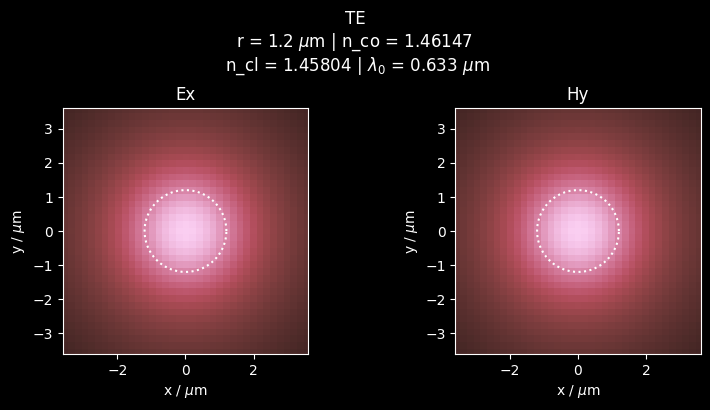

In [10]:
mode_files = modes['mode_files']
num_modes = len(mode_files)
full_title = 'r = {Core_radius} $\mu$m | n_co = {Core_index} \n n_cl = {Cladding_index} | $\lambda_0$ = {free_space_wavelength} $\mu$m'.format(**extra_config)
num_cols = int(np.ceil(np.sqrt(num_modes)))
num_rows = int(np.ceil(num_modes/num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
if 'polarization' in extra_config:
    if extra_config['polarization'] == 0:
        pol = 'TE'
    elif extra_config['polarization'] == 0:
        pol = 'TM'
    else:
        pol = ''
if num_modes == 1:
    ax = np.array([ax])
if len(ax.shape) == 1:
    ax = ax.reshape((1,ax.shape[0]))
job = []
radius = extra_config['Core_radius']
core_theta = np.linspace(0, 2*np.pi, 100)
core_x = radius*np.cos(core_theta)
core_y = radius*np.sin(core_theta)
for idx, filename in enumerate(mode_files):
    extent, lines, n_eff = load_mode_data(filename)
    if '_ex' in filename:
        field_component = 'Ex'
    elif '_hy' in filename:
        field_component = 'Hy'
    elif '_ey' in filename:
        field_component = 'Ey'
    elif '_hx' in filename:
        field_component = 'Hx'
    else:
        field_component = ''
    row = idx // num_cols
    col = idx % num_cols
    ax[row,col].set_ylabel('y / $\mu$m')
    ax[row,col].set_xlabel('x / $\mu$m')
    map_normalizer = max(np.max(lines), abs(np.min(lines)))
    ax[row,col].imshow(lines,
                extent=extent,
                cmap=cm.watermelon,
                aspect=1,
                vmin=-map_normalizer,
                vmax=map_normalizer,
                origin='lower')
    ax[row,col].plot(core_x, core_y, 'w:')
    ax[row,col].set_title(field_component)
    ax[row,col].set_xlim(-3*radius, 3*radius)
    ax[row,col].set_ylim(-3*radius, 3*radius)
    job.append((row,col))
for row in range(num_rows):
    for col in range(num_cols):
        if (row,col) not in job:
            ax[row,col].axis('off')
fig.suptitle('TE\n'+full_title)
plt.tight_layout()
plt.show()